<a href="https://colab.research.google.com/github/yootaka/AiQuest/blob/main/en4_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

演習４




In [ ]:
!python --version

Python 3.6.9


In [ ]:
!pip install -U torch torchvision

     |████████████████████████████████| 776.7MB 22kB/s 
     |████████████████████████████████| 12.8MB 231kB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [1]:
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models,transforms

#乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [8]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる


class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)),  # データオーギュメンテーション
   ##             transforms.transforms.TenCrop(resize),  # 左右反転して10か所切り抜き
   ##             transforms.Resize(resize),  # リサイズ
   ##             transforms.CenterCrop(resize),  # 画像中央をresize×resizeで切り取り
                transforms.RandomHorizontalFlip(),  # ランダムに左右反転
                transforms.RandomVerticalFlip(),  # ランダムに上下反転            
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ]),
            'test': transforms.Compose([
                transforms.Resize(resize),  # リサイズ
                transforms.CenterCrop(resize),  # 画像中央をresize×resizeで切り取り
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

In [3]:
#!pip install -U -q PyDrive

In [4]:
#ライブラリの読み込み
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials

In [5]:
#Google Cloud SDKの認証　必要？？
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


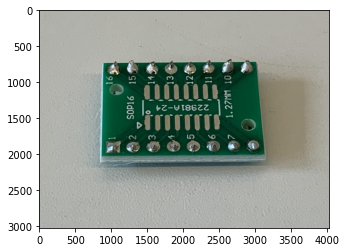

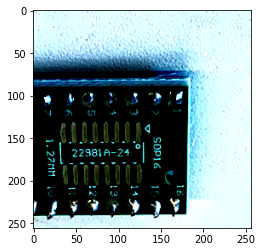

In [9]:
from google.colab import drive
drive.mount('/content/drive')

#@title デフォルトのタイトル テキスト
# 訓練時の画像前処理の動作を確認
# 実行するたびに処理結果の画像が変わる

# 1. 画像読み込み
image_file_path = './drive/My Drive/Colab Notebooks/AiQuest/en4/train/regular_001.jpeg'
img = Image.open(image_file_path)   # [高さ][幅][色RGB]

# 2. 元の画像の表示
plt.imshow(img)
plt.show()

# 3. 画像の前処理と処理済み画像の表示
size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")  # torch.Size([3, 256, 256])

# (色、高さ、幅)を (高さ、幅、色)に変換し、0-1に値を制限して表示
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [10]:
# train画像へのファイルパスのリストを作成する


def make_datapath_list(phase="train"):
    """
    データのパスを格納したリストを作成する。

    Parameters
    ----------
    phase : 'train' or 'test'
        訓練データか検証データかを指定する

    Returns
    -------
    path_list : list
        データへのパスを格納したリスト
    """

    rootpath = "./drive/My Drive/Colab Notebooks/AiQuest/en4/"
    target_path = osp.join(rootpath+phase+'/*.jpeg')
    print(target_path)

    path_list = []  # ここに格納する

    # globを利用してサブディレクトリまでファイルパスを取得する
    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list


# 実行
train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="test")

train_list

./drive/My Drive/Colab Notebooks/AiQuest/en4/train/*.jpeg
./drive/My Drive/Colab Notebooks/AiQuest/en4/test/*.jpeg


['./drive/My Drive/Colab Notebooks/AiQuest/en4/train/bridge_000.jpeg',
 './drive/My Drive/Colab Notebooks/AiQuest/en4/train/bridge_001.jpeg',
 './drive/My Drive/Colab Notebooks/AiQuest/en4/train/bridge_003.jpeg',
 './drive/My Drive/Colab Notebooks/AiQuest/en4/train/bridge_002.jpeg',
 './drive/My Drive/Colab Notebooks/AiQuest/en4/train/bridge_005.jpeg',
 './drive/My Drive/Colab Notebooks/AiQuest/en4/train/bridge_004.jpeg',
 './drive/My Drive/Colab Notebooks/AiQuest/en4/train/bridge_006.jpeg',
 './drive/My Drive/Colab Notebooks/AiQuest/en4/train/bridge_007.jpeg',
 './drive/My Drive/Colab Notebooks/AiQuest/en4/train/bridge_009.jpeg',
 './drive/My Drive/Colab Notebooks/AiQuest/en4/train/bridge_008.jpeg',
 './drive/My Drive/Colab Notebooks/AiQuest/en4/train/bridge_011.jpeg',
 './drive/My Drive/Colab Notebooks/AiQuest/en4/train/bridge_010.jpeg',
 './drive/My Drive/Colab Notebooks/AiQuest/en4/train/bridge_013.jpeg',
 './drive/My Drive/Colab Notebooks/AiQuest/en4/train/bridge_012.jpeg',
 './dr

In [20]:
# train画像のDatasetを作成する


class HymenopteraDataset(data.Dataset):
    """
    良品と不良品の画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'test'
        学習か訓練かを設定する。
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 400, 400])

        # 画像のラベルをファイル名から抜き出す
        if self.phase == "train":
            label = img_path[51:55]
        elif self.phase == "test":
  #        label = img_path[50:53]
           label = img_path[50:54]

 
        # ラベルを数値に変更する
        if label == "brid" or label == "horn" or label == "pota" :
            label = 1  #不良品
        elif label == "regu" :
            label = 0  #良品
#        elif label != "regu" and label != "brid" and label != "horn" and label != "pota" :
#            label = 0  #良品???????
############################### phase="test"
        return img_transformed, label


# 実行
train_dataset = HymenopteraDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = HymenopteraDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='test')

# 動作確認
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 256, 256])
1


In [21]:
# ミニバッチのサイズを指定
batch_size = 32

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "test": val_dataloader}

# 動作確認
batch_iterator = iter(dataloaders_dict["train"])  # イテレータに変換
inputs, labels = next(
    batch_iterator)  # 1番目の要素を取り出す
print(inputs.size())
print(labels)

torch.Size([32, 3, 256, 256])
tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 1, 0])


In [22]:
# 学習済みのVGG-16モデルをロード
# VGG-16モデルのインスタンスを生成
use_pretrained = True  # 学習済みのパラメータを使用
net = models.vgg16(pretrained=use_pretrained)

# VGG16の最後の出力層の出力ユニットを良品と不良品の2つに付け替える
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

# 訓練モードに設定
net.train()

print('ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました')

ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました


In [23]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

In [24]:
# 転移学習で学習させるパラメータを、変数params_to_updateに格納する
params_to_update = []

# 学習させるパラメータ名
update_param_names = ["classifier.6.weight", "classifier.6.bias"]

# 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

# params_to_updateの中身を確認
print("-----------")
print(params_to_update)

classifier.6.weight
classifier.6.bias
-----------
[Parameter containing:
tensor([[ 0.0089, -0.0113,  0.0120,  ...,  0.0093, -0.0136,  0.0050],
        [-0.0119,  0.0112, -0.0098,  ..., -0.0129,  0.0060,  0.0139]],
       requires_grad=True), Parameter containing:
tensor([0.0017, 0.0146], requires_grad=True)]


In [25]:
# 最適化手法の設定
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

In [26]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの学習と検証のループ
        for phase in ['train','test']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測
                    
  
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イタレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)  
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


In [27]:

# 学習・検証を実行する
num_epochs=2
result=train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/2
-------------



100%|██████████| 10/10 [05:27<00:00, 32.76s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

test Loss: 0.6445 Acc: 0.6517
Epoch 2/2
-------------



100%|██████████| 10/10 [05:16<00:00, 31.68s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

train Loss: 0.6816 Acc: 0.6298



100%|██████████| 10/10 [04:17<00:00, 25.78s/it]

test Loss: 0.6276 Acc: 0.6586


In [ ]:
# 結果を張り付け、ファイル出力
import pandas as pd
sample = pd.read_csv("./drive/My Drive/Colab Notebooks/AiQuest/en4/sample_submit.tsv",header=None,sep='\t')
sample[1] = result
sample.to_csv("./drive/My Drive/Colab Notebooks/AiQuest/en4/submit01.csv",index=None,header=None,sep='\t')

In [ ]:
print(result)

None
